In [2]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
ula_study = []

for i in range(100):
    ula_data = np.load('ula_hyperparameters_tuning/ula_iterations_number_tuning_sigma005/ula_data_'+str(900+i)+'.npy',allow_pickle=True)
    ula_study.append(ula_data.item())

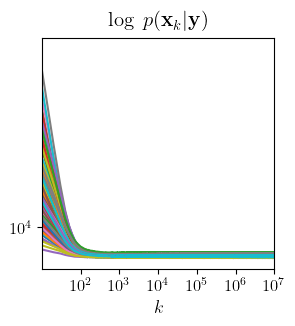

In [256]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})
for i in range(len(ula_study)):
    plt.plot(ula_study[i]["ula_obj_values"])
plt.xscale("log")
#plt.yscale("log")
plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6],
           [r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=12)
plt.yticks([1e4], [r"$10^4$"], fontsize=12)
plt.xlim([1,1e6])
plt.xlabel(r"$k$", fontsize=13, labelpad=5)
#plt.ylabel(r"$\log\;p(\mathbf{x}_k | \mathbf{y})$", rotation=90, fontsize=13, labelpad=10)
plt.title(r"$\log\;p(\mathbf{x}_k | \mathbf{y})$", fontsize=15, y=1.02)

plt.savefig('../../figures/ula_tuning_logposterior.eps', format='eps', bbox_inches="tight")

plt.show()

In [7]:
obj_values = np.zeros((len(ula_study), ula_study[0]["ula_obj_values"].size))

for i in range(len(ula_study)):
    avg_plateau = np.mean(ula_study[i]["ula_obj_values"][1100:])
    obj_values[i, :] =  ula_study[i]["ula_obj_values"] / avg_plateau
mean_obj_values = np.mean(obj_values, axis=0)
std_obj_values = np.std(obj_values, axis=0)

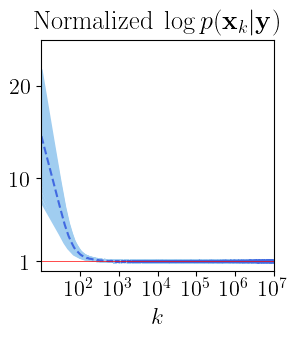

In [62]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

#plt.fill_between(np.arange(0,mean_obj_values.size), mean_obj_values-std_obj_values,  mean_obj_values+std_obj_values, color=np.array([0.62745098, 0.80588235, 0.94117647]))

upper_bound = mean_obj_values+std_obj_values
lower_bound = mean_obj_values-std_obj_values
step =  (upper_bound-lower_bound)/20

for i in range(21):
    plt.plot(lower_bound+step*i, color=np.array([0.62745098, 0.80588235, 0.94117647]), linewidth=2)
    

plt.plot(mean_obj_values, '--', color="royalblue")

plt.plot(np.ones(mean_obj_values.size),'r',linewidth=0.5)

#plt.plot(obj_values)
plt.xscale("log")

#plt.yscale("log")
#plt.yticks([1e1, 1e2], [r"$10^1$", r"$10^2$"], fontsize=12)

plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6],
           [r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=16)
plt.yticks([1,10,20], [r"$1$", r"$10$", r"$20$"], fontsize=16)
plt.xlim([1,1e6])
plt.ylim([-0.001, 25])
plt.xlabel(r"$k\phantom{-K_b}$", fontsize=17, labelpad=5)
#plt.ylabel(r"$\log\;p(\mathbf{x}_k | \mathbf{y})$", rotation=90, fontsize=13, labelpad=10)
plt.title(r"$\mathrm{Normalized}\; \log p(\mathbf{x}_k | \mathbf{y})$", fontsize=19, y=1.01)

plt.savefig('../../figures/ula_tuning_logposterior_avg.eps', format='eps', bbox_inches="tight")

plt.show()

In [18]:
mapes_mean, mapes_var, mapes_std = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25))
mses_mean, mses_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 

for i in range(len(ula_study)):
    
    mean_items, var_items, std_items, mean_prad_items, var_prad_items = [], [], [], [], []
    for k in ula_study[i].keys():
        if 'mean' in k and 'prad' not in k:
            mean_items.append(ula_study[i][k])
        if 'var' in k and 'prad' not in k:
            var_items.append(ula_study[i][k])
            std_items.append(np.sqrt(ula_study[i][k]))
        if 'mean_prad' in k:
            mean_prad_items.append(ula_study[i][k])
        if 'var_prad' in k:
            var_prad_items.append(ula_study[i][k])
    mean_items, var_items, std_items = np.array(mean_items), np.array(var_items), np.array(std_items)
    mean_prad_items, var_prad_items = np.array(mean_prad_items), np.array(var_prad_items)
    
    
    mses_mean[i,:] = np.mean((mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))**2, axis=(1,2))
    mape_mean = np.abs(mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))
    mean_positive_locs = np.where(mean_items[-1]>1e-3)
    mape_mean[:,mean_positive_locs[0], mean_positive_locs[1]] /= mean_items[-1][mean_positive_locs[0], mean_positive_locs[1]]
    mapes_mean[i,:] = np.mean(mape_mean[:,mean_positive_locs[0],mean_positive_locs[1]],axis=1)
    
    mses_var[i,:] = np.mean((var_items-np.stack([var_items[-1]]*var_items.shape[0]))**2, axis=(1,2))
    mape_var = np.abs(var_items-np.stack([var_items[-1]]*var_items.shape[0]))
    var_positive_locs = np.where(var_items[-1]>1e-3)
    mape_var[:,var_positive_locs[0], var_positive_locs[1]] /= var_items[-1][var_positive_locs[0], var_positive_locs[1]]
    mapes_var[i,:] = np.mean(mape_var[:,var_positive_locs[0],var_positive_locs[1]],axis=1)
    
    mape_std = np.abs(std_items-np.stack([std_items[-1]]*std_items.shape[0]))
    mape_std[:,var_positive_locs[0], var_positive_locs[1]] /= std_items[-1][var_positive_locs[0], var_positive_locs[1]]
    mapes_std[i,:] = np.mean(mape_std[:,var_positive_locs[0],var_positive_locs[1]], axis=1)
    


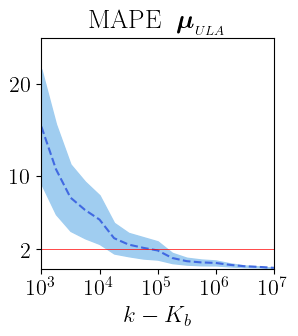

In [48]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'text.latex.preamble': r"""\usepackage{bm}""",
})
mape_mean_avg = np.mean(mapes_mean[:,8:],axis=0)
mape_mean_std = np.std(mapes_mean[:,8:],axis=0)
#plt.fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, alpha=0.5)
plt.fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, color=np.array([0.62745098, 0.80588235, 0.94117647]))
plt.plot(mape_mean_avg, '--', color="royalblue")
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=16)
#plt.yticks([0,0.02,0.1,0.2,0.3], [r"$0$",r"$2$",r"$10$",r"$20$",r"$30$"], fontsize=14)
plt.yticks([0.02,0.1,0.2,0.3], [r"$2$",r"$10$",r"$20$",r"$30$"], fontsize=16)
plt.plot(np.ones(int(17))*0.02,'r',linewidth=0.5)
plt.ylim([-0.001,0.25])
plt.xlim([0,16])
plt.title(r"$\mathrm{MAPE}\;\;\bm{\mu}_{_{ULA}}$", fontsize=19, y=1.01)
plt.xlabel(r"$k-K_b$", fontsize=17, labelpad=5)

plt.savefig('../../figures/ula_tuning_mape_mean.eps', format='eps', bbox_inches="tight")
plt.show()

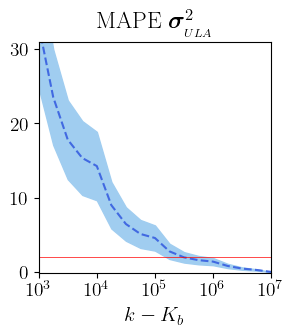

In [49]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'text.latex.preamble': r"""\usepackage{bm}""",
})
mape_var_avg = np.mean(mapes_var[:,8:],axis=0)
mape_var_std = np.std(mapes_var[:,8:],axis=0)
#plt.fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, alpha=0.5)
plt.fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, color=np.array([0.62745098, 0.80588235, 0.94117647]))
plt.plot(mape_var_avg, '--', color="royalblue")
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=14)
plt.yticks([0,0.1,0.2,0.3], [r"$0$",r"$10$",r"$20$",r"$30$"], fontsize=14)
plt.plot(np.ones(int(17))*0.02,'r',linewidth=0.5)
plt.ylim([-0.001,0.31])
plt.xlim([0,16])
plt.title(r"$\mathrm{MAPE}\;\bm{\sigma}^2_{_{ULA}}$", fontsize=17, y=1.02)
plt.xlabel(r"$k-K_b$", fontsize=15, labelpad=5)

plt.savefig('../../figures/ula_tuning_mape_var.eps', format='eps', bbox_inches="tight")
plt.show()

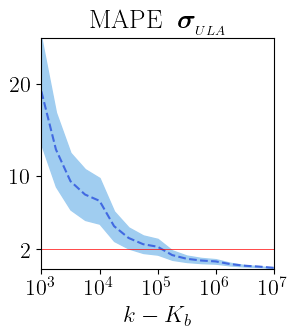

In [50]:
plt.figure(figsize=(3,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'text.latex.preamble': r"""\usepackage{bm}""",
})
mape_std_avg = np.mean(mapes_std[:,8:],axis=0)
mape_std_std = np.std(mapes_std[:,8:],axis=0)
#plt.fill_between(np.arange(0,17), mape_std_avg-mape_std_std,  mape_std_avg+mape_std_std, alpha=0.5)
#plt.fill_between(np.arange(0,17), mape_std_avg-mape_std_std,  mape_std_avg+mape_std_std, color=np.array([0.62745098, 0.70588235, 0.94117647]))
plt.fill_between(np.arange(0,17), mape_std_avg-mape_std_std,  mape_std_avg+mape_std_std, color=np.array([0.62745098, 0.80588235, 0.94117647]))
plt.plot(mape_std_avg, '--', color="royalblue")
plt.xticks([0,4,8,12,16], [r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"], fontsize=16)
#plt.yticks([0,0.02,0.1,0.2,0.3], [r"$0$",r"$2$",r"$10$",r"$20$",r"$30$"], fontsize=14)
plt.yticks([0.02,0.1,0.2,0.3], [r"$2$",r"$10$",r"$20$",r"$30$"], fontsize=16)
plt.plot(np.ones(int(17))*0.02,'r',linewidth=0.5)
plt.ylim([-0.001,0.25])
plt.xlim([0,16])
plt.title(r"$\mathrm{MAPE}\;\;\bm{\sigma}_{_{ULA}}$", fontsize=19, y=1.01)
plt.xlabel(r"$k-K_b$", fontsize=17, labelpad=5)

plt.savefig('../../figures/ula_tuning_mape_std.eps', format='eps', bbox_inches="tight")
plt.show()

In [184]:
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from matplotlib.colors import colorConverter as cC
import numpy as np

__version__ = "0.22"
__author__ = "Francesco Montesano (franz.bergesund@gmail.com)"

__all__ = ["colorAlpha_to_rgb"]

def _to_rgb(c):
    """
    Convert color *c* to a numpy array of *RGB* handling exeption
    Parameters
    ----------
    c: Matplotlib color
        same as *color* in *colorAlpha_to_rgb*
    output
    ------
    rgbs: list of numpy array
        list of c converted to *RGB* array
    """

    if(getattr(c, '__iter__', False) == False):  #if1: if c is a single element (number of string)
        rgbs = [np.array(cC.to_rgb(c)),]  #list with 1 RGB numpy array

    else:  #if1, else: if is more that one element

        try:   #try1: check if c is numberic or not
            np.array(c) + 1

        except (TypeError, ValueError):  #try1: if not numerics is not (only) RGB or RGBA colors
            #convert the list/tuble/array of colors into a list of numpy arrays of RGB
            rgbs = [np.array( cC.to_rgb(i)) for i in c]

        except Exception as e:  #try1: if any other exception raised
            print("Unexpected error: {}".format(e))
            raise e #raise it

        else:  #try1: if the colors are all numberics

            arrc = np.array(c)  #convert c to a numpy array
            arrcsh = arrc.shape  #shape of the array 

            if len(arrcsh)==1:  #if2: if 1D array given 
                if(arrcsh[0]==3 or arrcsh[0]==4):  #if3: if RGB or RBGA
                    rgbs = [np.array(cC.to_rgb(c)),]  #list with 1 RGB numpy array
                else:   #if3, else: the color cannot be RBG or RGBA
                    raise ValueError('Invalid rgb arg "{}"'.format(c))
                #end if3
            elif len(arrcsh)==2:  #if2, else: if 2D array
                if(arrcsh[1]==3 or arrcsh[1]==4):  #if4: if RGB or RBGA
                    rgbs = [np.array(cC.to_rgb(i)) for i in c]  #list with RGB numpy array
                else:   #if4, else: the color cannot be RBG or RGBA
                    raise ValueError('Invalid list or array of rgb')
                #end if4
            else:  #if2, else: if more dimention
                raise ValueError('The rgb or rgba values must be contained in a 1D or 2D list or array')
            #end if2
        #end try1
    #end if1

    return rgbs

def _is_number(s):
    """
    Check if *c* is a number (from
    http://stackoverflow.com/questions/354038/how-do-i-check-if-a-string-is-a-number-in-python)
    Parameters
    ----------
    c: variable
    output
    ------
    true if c is a number
    false otherwise
    """
    try:
        float(s) # for int, long and float
    except ValueError:
        return False
    return True

def _check_alpha(alpha, n):
    """
    Check if alpha has one or n elements and if they are numberics and between 0 and 1
    Parameters
    ----------
    alpha: number or list/tuple/numpy array of numbers
        values to check
    output
    ------
    alpha: list of numbers 
        if all elements numberics and between 0 and 1
    """
    alpha = np.array(alpha).flatten()  #convert alpha to a flattened array
    if(alpha.size == 1):  #if1: alpha is one element
        if(_is_number(alpha) == False or alpha < 0 or alpha > 1):
            raise ValueError("'alpha' must be a float with value between 0 and 1, included") 
        else:
            alpha = [alpha for i in range(n)]  #replicate the alphas len(colors) times
    elif(alpha.size==n):  #if1, else: if alpha is composed of len(colors) elements
        try:  #check if all alphas are numbers
            alpha+1 
        except TypeError:
            raise ValueError("All elements of alpha must be a float with value between 0 and 1, included") 
        else:
            if((alpha < 0).any() or (alpha > 1).any()):
                raise ValueError("'alpha' must be a float with value between 0 and 1, included") 
    else:  #if1, else: if none of the previous cases
        raise ValueError("Alpha must have either one element or as many as 'colors'")
    #end if1
    return alpha

def colorAlpha_to_rgb(colors, alpha, bg='w'):
    """
    Given a Matplotlib color and a value of alpha, it returns 
    a RGB color which mimic the RGBA colors on the given background

    Parameters
    ----------
    colors: Matplotlib color (documentation from matplotlib.colors.colorConverter.to_rgb), 
        list/tuple/numpy array of colors
        Can be an *RGB* or *RGBA* sequence or a string in any of
        several forms:
        1) a letter from the set 'rgbcmykw'
        2) a hex color string, like '#00FFFF'
        3) a standard name, like 'aqua'
        4) a float, like '0.4', indicating gray on a 0-1 scale
        if *color* is *RGBA*, the *A* will simply be discarded.
    alpha: float [0,1] or list/tuple/numpy array with len(colors) elements
        Value of alpha to mimic. 
    bg: Matplotlib color (optional, default='w')
        Color of the background. Can be of any type shown in *color*

    output
    ------
    rgb: *RGB* color 

    example
    -------

    import mimic_alpha as ma

    print(ma.colorAlpha_to_rgb('r', 0.5))
    >>> [array([ 1. ,  0.5,  0.5])]
    print(ma.colorAlpha_to_rgb(['r', 'g'], 0.5)) 
    >>> [array([ 1. ,  0.5,  0.5]), array([ 0.5 ,  0.75,  0.5 ])]
    print(ma.colorAlpha_to_rgb(['r', 'g'], [0.5, 0.3])) 
    >>> [array([ 1. ,  0.5,  0.5]), array([ 0.7 ,  0.85,  0.7 ])]
    print(ma.colorAlpha_to_rgb(['r', [1,0,0]], 0.5)) 
    >>> [array([ 1. ,  0.5,  0.5]), array([ 1. ,  0.5,  0.5])]
    print( ma.colorAlpha_to_rgb([[0,1,1], [1,0,0]], 0.5) ) 
    >>> [array([ 0.5,  1. ,  1. ]), array([ 1. ,  0.5,  0.5])]
    print(ma.colorAlpha_to_rgb(np.array([[0,1,1], [1,0,0]]), 0.5)) 
    >>> [array([ 0.5,  1. ,  1. ]), array([ 1. ,  0.5,  0.5])]
    print(ma.colorAlpha_to_rgb(np.array([[0,1,1], [1,0,0]]), 0.5, bg='0.5')) 
    >>> [array([ 0.25,  0.75,  0.75]), array([ 0.75,  0.25,  0.25])]
    """

    colors = _to_rgb(colors)  #convert the color and save in a list of np arrays
    bg = np.array(cC.to_rgb(bg))   #convert the background

    #check if alpha has 1 or len(colors) elements and return a list of len(color) alpha 
    alpha = _check_alpha(alpha, len(colors))  
    #interpolate between background and color 
    rgb = [(1.-a) * bg + a*c for c,a in zip(colors, alpha)]

    return rgb


def cmap(cmap_name, alpha, bg="w", set_under=None, set_over=None,
         set_bad=None, out_cmap_name=None):
    """
    Generate an RGB colormap from a given mpl cmap and alpha value.

    Parameters
    ----------
    cmap_name: String
       A standard Matplotlib colormap name:
       http://matplotlib.org/examples/color/colormaps_reference.html
    alpha: Float
       Value of alpha to mimic in range [0,1].
    bg: Matplotlib color
       Color of the background.
    out_cmap_name: String
       Name of the returned colormap.
    set_under: Matplotlib color
       Set color to be used for low out-of-range values.
    set_over: Matplotlib color
       Set color to be used for high out-of-range values.
    set_bad: Matplotlib color
       Set color to be used for masked values.

    Output
    ------
    ma_cmap: :class:`matplotlib.colors.Colormap`
       A colormap instance that mimics an RGBA standard cmap.

    Notes
    -----
    This code is based on the make_cmap() program written by Chris Slocum:
      http://schubert.atmos.colostate.edu/~cslocum/custom_cmap.html

    Example
    -------
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> import mimic_alpha as ma

    >>> plt.ion()

    >>> # Make a gradient image:
    >>> gradient = np.linspace(0, 1, 50)
    >>> image = np.repeat(np.atleast_2d(gradient), repeats=2, axis=0)

    >>> # Compare contourf() plots without alpha, with alpha, and mimic-alpha:
    >>> plt.figure(0)
    >>> plt.clf()
    >>> plt.subplots_adjust(0.1, 0.1, 0.95, 0.95, hspace=0.4)
    >>> ax = plt.subplot(411)
    >>> ax.set_title("Standard 'hot' colormap")
    >>> cs = plt.contourf(image, levels=gradient, cmap="hot")
    >>> ax.set_xticklabels([""])
    >>> ax = plt.subplot(412)
    >>> mahot = ma.cmap("hot", 1.0)
    >>> ax.set_title("Mimic-alpha 'hot' colormap with alpha=1.0")
    >>> cs = plt.contourf(image, levels=gradient, cmap=mahot)
    >>> ax.set_xticklabels([""])
    >>> ax = plt.subplot(413)
    >>> ax.set_title("Standard 'hot' colormap with alpha=0.5")
    >>> cs = plt.contourf(image, levels=gradient, cmap="hot", alpha=0.5)
    >>> ax.set_xticklabels([""])
    >>> ax = plt.subplot(414)
    >>> mahot = ma.cmap("hot", 0.5)
    >>> ax.set_title("Mimic-alpha 'hot' colormap with alpha=0.5")
    >>> cs = plt.contourf(image, levels=gradient, cmap=mahot)

    >>> # Compare outputs when saved as a postscript file:
    >>> plt.savefig("mimic_alpha_hot.ps")
    """
    # Read input cmap:
    input_cmap = plt.cm.get_cmap(cmap_name)
    ncolors = input_cmap.N

    position = np.linspace(0, 1, ncolors)
    # Convert RGBA colors from cmap into RGB:
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos in position:
        r, g, b = colorAlpha_to_rgb(input_cmap(pos), alpha, bg)[0]
        cdict['red'  ].append((pos, r, r))
        cdict['green'].append((pos, g, g))
        cdict['blue' ].append((pos, b, b))

    # Set output colormap name:
    if out_cmap_name is None:
        out_cmap_name = cmap_name + "_{0:.1f}".format(alpha)
    # mimic-alpha colormap:
    ma_cmap = mplc.LinearSegmentedColormap(out_cmap_name, cdict, 256)

    # Set mimic-alpha colors for masked and out-of-range values:
    if set_under is not None:
        RGBunder = colorAlpha_to_rgb(set_under, alpha, bg)[0]
        ma_cmap.set_under(RGBunder)
    if set_over is not None:
        RGBover  = colorAlpha_to_rgb(set_over,  alpha, bg)[0]
        ma_cmap.set_over(RGBover)
    if set_bad is not None:
        RGBbad   = colorAlpha_to_rgb(set_bad,   alpha, bg)[0]
        ma_cmap.set_bad(RGBbad)

    return ma_cmap

In [190]:
colorAlpha_to_rgb(colors=['royalblue'], alpha=0.5)

/tmp/ipykernel_181108/1228058802.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(s) # for int, long and float


[array([0.62745098, 0.70588235, 0.94117647])]

In [126]:
# fig, ax = plt.subplots(1,2,figsize=(10,3))
# plt.subplots_adjust(wspace=0.1)
# mse_mean_avg = np.mean(mses_mean[:,8:],axis=0)
# mse_mean_std = np.std(mses_mean[:,8:],axis=0)
# ax[0].plot(mse_mean_avg, '--', color="royalblue")
# ax[0].fill_between(np.arange(0,17), mse_mean_avg-mse_mean_std,  mse_mean_avg+mse_mean_std, alpha=0.5)
# ax[0].set_xticks([0,4,8,12,16])
# ax[0].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
# #ax[0].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
# #ax[0].set_ylim([-0.001,0.41])
# ax[0].set_xlim([0,16])
# ax[0].set_title(r"MSE $\;\mu_{_{ULA}}$", fontsize=15)
# 
# mse_var_avg = np.mean(mses_var[:,8:],axis=0)
# mse_var_std = np.std(mses_var[:,8:],axis=0)
# ax[1].plot(mse_var_avg, '--', color="royalblue")
# ax[1].fill_between(np.arange(0,17), mse_var_avg-mse_var_std,  mse_var_avg+mse_var_std, alpha=0.5)
# ax[1].set_xticks([0,4,8,12,16])
# ax[1].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
# #ax[1].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
# ax[1].set_ylim([-1e-7,2e-5])
# ax[1].set_xlim([0,16])
# ax[1].set_title(r"MSE $\sigma_{_{ULA}}$", fontsize=15)

In [87]:
ula_study[0].keys()

dict_keys(['tomo_data', 'noisy_tomo_data', 'sigma_err', 'reg_param', 'sampling', 'alpha', 'with_pos_constraint', 'clip_iterations', 'samples', 'mean_10', 'var_10', 'mean_prad_10', 'var_prad_10', 'time_10', 'mean_25', 'var_25', 'mean_prad_25', 'var_prad_25', 'time_25', 'mean_50', 'var_50', 'mean_prad_50', 'var_prad_50', 'time_50', 'mean_75', 'var_75', 'mean_prad_75', 'var_prad_75', 'time_75', 'mean_100', 'var_100', 'mean_prad_100', 'var_prad_100', 'time_100', 'mean_250', 'var_250', 'mean_prad_250', 'var_prad_250', 'time_250', 'mean_500', 'var_500', 'mean_prad_500', 'var_prad_500', 'time_500', 'mean_750', 'var_750', 'mean_prad_750', 'var_prad_750', 'time_750', 'mean_1000', 'var_1000', 'mean_prad_1000', 'var_prad_1000', 'time_1000', 'mean_2500', 'var_2500', 'mean_prad_2500', 'var_prad_2500', 'time_2500', 'mean_5000', 'var_5000', 'mean_prad_5000', 'var_prad_5000', 'time_5000', 'mean_7500', 'var_7500', 'mean_prad_7500', 'var_prad_7500', 'time_7500', 'mean_10000', 'var_10000', 'mean_prad_100

In [88]:
f1=ula_study[0]["var_10000000"]
f2=ula_study[0]["var_1000000"]

In [91]:
is_core = np.where(f1>1e-3)

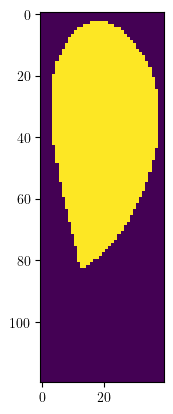

In [92]:
tbp=np.zeros((120,40))
tbp[is_core]=1
plt.imshow(tbp)

In [121]:
f1s=np.zeros(100)
f2s=np.zeros(100)
for id in range(100):
    f1=ula_study[id]["var_10000000"]
    f2=ula_study[id]["var_100000"]
    #print(100*np.mean(np.abs(f1-f2)/f1))
    f1s[id]=100*np.mean(np.abs(f1-f2)/f1)
    #print(100*np.mean(np.abs(f1**2-f2**2)/(f1**2)))
    f2s[id]=100*np.mean(np.abs(f1**2-f2**2)/(f1**2))

In [122]:
np.mean(f1s)

np.float64(1.871561922982377)

In [111]:
np.mean(np.abs(f1**2-f2**2)/(f1**2))

np.float64(0.04550458412647054)

In [120]:
100*mape_var_avg

array([8.06712796, 5.37684506, 3.91106925, 3.28954107, 2.98757103,
       1.86219974, 1.32837509, 1.05804203, 0.93775219, 0.56941947,
       0.40368812, 0.32698659, 0.28569551, 0.16512285, 0.09269908,
       0.05364372, 0.        ])

In [117]:
mapes_mean, mapes_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 
mses_mean, mses_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 

for i in range(len(ula_study)):
    
    mean_items, var_items, mean_prad_items, var_prad_items = [], [], [], []
    for k in ula_study[i].keys():
        if 'mean' in k and 'prad' not in k:
            mean_items.append(ula_study[i][k])
        if 'var' in k and 'prad' not in k:
            var_items.append(np.sqrt(ula_study[i][k]))
        if 'mean_prad' in k:
            mean_prad_items.append(ula_study[i][k])
        if 'var_prad' in k:
            var_prad_items.append(np.sqrt(ula_study[i][k]))
    mean_items, var_items = np.array(mean_items), np.array(var_items)
    mean_prad_items, var_prad_items = np.array(mean_prad_items), np.array(var_prad_items)
    
    
    mses_mean[i,:] = np.mean((mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))**2, axis=(1,2))
    mape_mean = np.abs(mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))
    mean_positive_locs = np.where(mean_items[-1]>1e-3)
    mape_mean[:,mean_positive_locs[0], mean_positive_locs[1]] /= mean_items[-1][mean_positive_locs[0], mean_positive_locs[1]]
    mapes_mean[i,:] = np.mean(mape_mean[:,mean_positive_locs[0],mean_positive_locs[1]],axis=1)
    
    mses_var[i,:] = np.mean((var_items-np.stack([var_items[-1]]*var_items.shape[0]))**2, axis=(1,2))
    mape_var = np.abs(var_items-np.stack([var_items[-1]]*var_items.shape[0]))
    var_positive_locs = np.where(var_items[-1]>1e-3)
    mape_var[:,var_positive_locs[0], var_positive_locs[1]] /= var_items[-1][var_positive_locs[0], var_positive_locs[1]]
    mapes_var[i,:] = np.mean(mape_var[:,var_positive_locs[0],var_positive_locs[1]],axis=1)


Text(0.5, 1.0, 'MAPE $\\sigma_{_{ULA}}$')

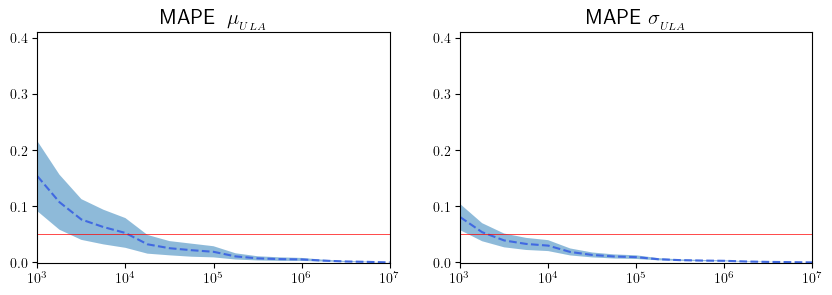

In [80]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace=0.2)

mape_mean_avg = np.mean(mapes_mean[:,8:],axis=0)
mape_mean_std = np.std(mapes_mean[:,8:],axis=0)
ax[0].plot(mape_mean_avg, '--', color="royalblue")
ax[0].fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, alpha=0.5)
ax[0].set_xticks([0,4,8,12,16])
ax[0].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
ax[0].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[0].set_ylim([-0.001,0.41])
ax[0].set_xlim([0,16])
ax[0].set_title(r"MAPE $\;\mu_{_{ULA}}$", fontsize=15)

mape_var_avg = np.mean(mapes_var[:,8:],axis=0)
mape_var_std = np.std(mapes_var[:,8:],axis=0)
ax[1].plot(mape_var_avg, '--', color="royalblue")
ax[1].fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, alpha=0.5)
ax[1].set_xticks([0,4,8,12,16])
ax[1].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
ax[1].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[1].set_ylim([-0.001,0.41])
ax[1].set_xlim([0,16])
ax[1].set_title(r"MAPE $\sigma_{_{ULA}}$", fontsize=15)
#ax[1].set_xlabel(r"$N_{ULA}$")